## 📦 Step 1: Importar Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import random

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Librerías importadas correctamente")
print(f"PyTorch versión: {torch.__version__}")

# Configurar dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 GPU NVIDIA detectada (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 GPU Apple Silicon detectada (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Usando CPU")

print(f"🖥️  Dispositivo de cómputo: {device}")

✅ Librerías importadas correctamente
PyTorch versión: 2.9.1
🍎 GPU Apple Silicon detectada (MPS)
🖥️  Dispositivo de cómputo: mps


## ⚙️ Step 2: Configuración

In [2]:
# ============================================
# CONFIGURACIÓN
# ============================================

# Rutas
DATA_DIR = Path("../data")
MODELS_DIR = Path("../models")

# Modelo pre-entrenado con datos sintéticos
# Usamos el modelo de CnnModel2 que fue entrenado con CoSiBD
PRETRAINED_MODEL_PATH = Path("../../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth")

# Parámetros del modelo
INPUT_SIZE = 1000
OUTPUT_SIZE = 5000
UPSAMPLE_FACTOR = OUTPUT_SIZE // INPUT_SIZE  # 5x

# Parámetros de fine-tuning
FINETUNE_EPOCHS = 40  # Menos épocas que entrenamiento completo
BATCH_SIZE = 32
LEARNING_RATE = 1e-4  # Learning rate más bajo para fine-tuning

print("="*60)
print("CONFIGURACIÓN - MODELO TUNNED-AUDIO")
print("="*60)
print(f"📂 Datos: {DATA_DIR}")
print(f"💾 Modelos: {MODELS_DIR}")
print(f"🧠 Modelo pre-entrenado: {PRETRAINED_MODEL_PATH}")
print(f"   Existe: {PRETRAINED_MODEL_PATH.exists()}")
print(f"\n--- Fine-tuning ---")
print(f"🔄 Épocas: {FINETUNE_EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"📈 Learning rate: {LEARNING_RATE} (reducido para fine-tuning)")
print("="*60)

CONFIGURACIÓN - MODELO TUNNED-AUDIO
📂 Datos: ../data
💾 Modelos: ../models
🧠 Modelo pre-entrenado: ../../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth
   Existe: True

--- Fine-tuning ---
🔄 Épocas: 40
📦 Batch size: 32
📈 Learning rate: 0.0001 (reducido para fine-tuning)


## 📥 Step 3: Cargar Datos de Audio

In [3]:
training_dir = DATA_DIR / "training"

x_audio_train = np.loadtxt(training_dir / "x_audio_train.txt")
y_audio_train = np.loadtxt(training_dir / "y_audio_train.txt")

x_test = np.loadtxt(training_dir / "x_audio_test.txt")
y_test = np.loadtxt(training_dir / "y_audio_test.txt")

print("="*60)
print("DATOS DE AUDIO CARGADOS")
print("="*60)
print(f"📊 Fine-tuning:")
print(f"   x_audio_train: {x_audio_train.shape}")
print(f"   y_audio_train: {y_audio_train.shape}")
print(f"\n📊 Test:")
print(f"   x_test: {x_test.shape}")
print(f"   y_test: {y_test.shape}")
print("="*60)

DATOS DE AUDIO CARGADOS
📊 Fine-tuning:
   x_audio_train: (500, 1000)
   y_audio_train: (500, 5000)

📊 Test:
   x_test: (125, 1000)
   y_test: (125, 5000)


## 🏗️ Step 4: Definir Arquitectura (Compatible con Modelo Pre-entrenado)

In [4]:
class TimeSeriesSRNet(nn.Module):
    """
    Versión CON BatchNorm (compatible con best_model_upsample5x.pth).
    """
    def __init__(self, input_size=1000, output_size=5000, hidden_channels=[64, 128, 256]):
        super(TimeSeriesSRNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_channels[0], kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[0], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[1], hidden_channels[2], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[2]),
            nn.ReLU(inplace=True),
        )
        
        # Upsampler
        self.upsample = nn.Sequential(
            nn.Upsample(size=output_size, mode='linear', align_corners=True),
            nn.Conv1d(hidden_channels[2], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[1], hidden_channels[0], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[0], 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.upsample(features)
        return output


print("✅ Arquitectura TimeSeriesSRNet definida (con BatchNorm)")

✅ Arquitectura TimeSeriesSRNet definida (con BatchNorm)


## 📥 Step 5: Cargar Modelo Pre-entrenado

In [5]:
# Crear modelo
model = TimeSeriesSRNet(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)

# Cargar pesos pre-entrenados
if PRETRAINED_MODEL_PATH.exists():
    checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location=device, weights_only=False)
    
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Modelo pre-entrenado cargado (época {checkpoint.get('epoch', 'N/A')})")
        if checkpoint.get('val_loss'):
            print(f"   Val Loss pre-entrenamiento: {checkpoint.get('val_loss'):.6f}")
    else:
        model.load_state_dict(checkpoint)
        print(f"✅ Modelo pre-entrenado cargado (state_dict directo)")
    
    model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Parámetros totales: {total_params:,}")
    print(f"   Dispositivo: {device}")
else:
    print(f"❌ ERROR: No se encontró el modelo pre-entrenado en {PRETRAINED_MODEL_PATH}")

✅ Modelo pre-entrenado cargado (época 30)
   Val Loss pre-entrenamiento: 0.084546
   Parámetros totales: 412,673
   Dispositivo: mps


## 📊 Step 6: Evaluar Modelo ANTES del Fine-tuning

In [6]:
def evaluate_model(model, x_test, y_test, device):
    model.eval()
    criterion = nn.L1Loss()
    
    with torch.no_grad():
        x_tensor = torch.tensor(x_test[:, np.newaxis, :], dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_test[:, np.newaxis, :], dtype=torch.float32).to(device)
        
        y_pred = model(x_tensor)
        loss = criterion(y_pred, y_tensor)
        
    return loss.item(), y_pred.cpu().numpy().squeeze()


# Evaluar ANTES del fine-tuning
loss_before, _ = evaluate_model(model, x_test, y_test, device)
print(f"📊 Loss ANTES del fine-tuning (audio test): {loss_before:.6f}")

📊 Loss ANTES del fine-tuning (audio test): 0.067937


## 🔧 Step 7: Fine-tuning con Datos de Audio

In [7]:
def finetune_model(model, x_train, y_train, epochs, batch_size, lr, device):
    """
    Fine-tuning del modelo con learning rate reducido.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    
    dataset_size = x_train.shape[0]
    indices = np.arange(dataset_size)
    
    loss_history = []
    
    for epoch in range(epochs):
        np.random.shuffle(indices)
        epoch_loss = 0.0
        
        for start_idx in range(0, dataset_size, batch_size):
            end_idx = min(start_idx + batch_size, dataset_size)
            batch_idx = indices[start_idx:end_idx]
            
            x_batch = torch.tensor(x_train[batch_idx][:, np.newaxis, :], dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_train[batch_idx][:, np.newaxis, :], dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * x_batch.size(0)
        
        avg_loss = epoch_loss / dataset_size
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")
    
    return loss_history


print("="*60)
print("FINE-TUNING - MODELO TUNNED-AUDIO")
print("="*60)

loss_history = finetune_model(
    model, x_audio_train, y_audio_train,
    epochs=FINETUNE_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    device=device
)

print("="*60)
print("✅ FINE-TUNING COMPLETADO")
print("="*60)

FINE-TUNING - MODELO TUNNED-AUDIO
Epoch [1/40] - Loss: 2.071624
Epoch [5/40] - Loss: 0.948607
Epoch [10/40] - Loss: 0.222108
Epoch [15/40] - Loss: 0.059516
Epoch [20/40] - Loss: 0.036894
Epoch [25/40] - Loss: 0.025083
Epoch [30/40] - Loss: 0.020738
Epoch [35/40] - Loss: 0.018273
Epoch [40/40] - Loss: 0.018181
✅ FINE-TUNING COMPLETADO


## 📊 Step 8: Evaluar Modelo DESPUÉS del Fine-tuning

In [8]:
loss_after, y_pred = evaluate_model(model, x_test, y_test, device)

print("="*60)
print("COMPARACIÓN: ANTES vs DESPUÉS DEL FINE-TUNING")
print("="*60)
print(f"📊 Loss ANTES:   {loss_before:.6f}")
print(f"📊 Loss DESPUÉS: {loss_after:.6f}")
improvement = ((loss_before - loss_after) / loss_before) * 100
print(f"📈 Mejora: {improvement:.2f}%")
print("="*60)

COMPARACIÓN: ANTES vs DESPUÉS DEL FINE-TUNING
📊 Loss ANTES:   0.067937
📊 Loss DESPUÉS: 0.015231
📈 Mejora: 77.58%


## 📊 Step 9: Visualizar Entrenamiento

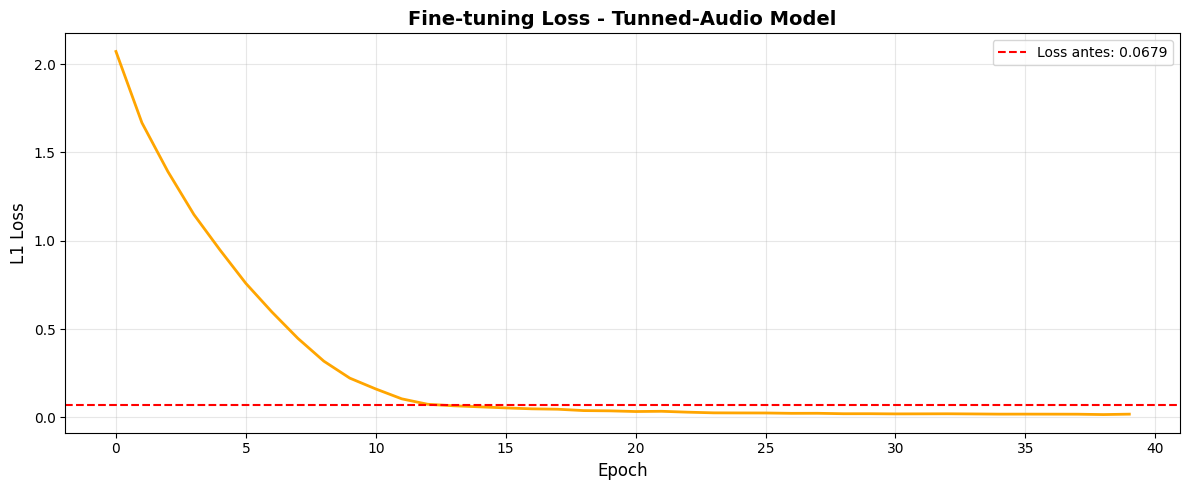


📈 Loss final: 0.018181
📉 Loss mínimo: 0.015831


In [9]:
plt.figure(figsize=(12, 5))
plt.plot(loss_history, 'orange', linewidth=2)
plt.axhline(y=loss_before, color='r', linestyle='--', label=f'Loss antes: {loss_before:.4f}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('L1 Loss', fontsize=12)
plt.title('Fine-tuning Loss - Tunned-Audio Model', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📈 Loss final: {loss_history[-1]:.6f}")
print(f"📉 Loss mínimo: {min(loss_history):.6f}")

## 💾 Step 10: Guardar Modelo

In [10]:
model_path = MODELS_DIR / "timeseries_srnet_audio_tunned.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Modelo guardado: {model_path}")

✅ Modelo guardado: ../models/timeseries_srnet_audio_tunned.pth


## 📈 Step 11: Métricas Detalladas

In [11]:
from scipy.stats import pearsonr

def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    correlations = [pearsonr(y_true[i], y_pred[i])[0] for i in range(len(y_true))]
    mean_corr = np.mean(correlations)
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Mean Correlation': mean_corr}


metrics = calculate_metrics(y_test, y_pred)

print("="*60)
print("MÉTRICAS - MODELO TUNNED-AUDIO")
print("="*60)
for metric, value in metrics.items():
    print(f"📊 {metric}: {value:.6f}")
print("="*60)

MÉTRICAS - MODELO TUNNED-AUDIO
📊 MAE: 0.015231
📊 MSE: 0.000606
📊 RMSE: 0.024626
📊 Mean Correlation: 0.757508


## 📊 Step 12: Visualizar Predicciones

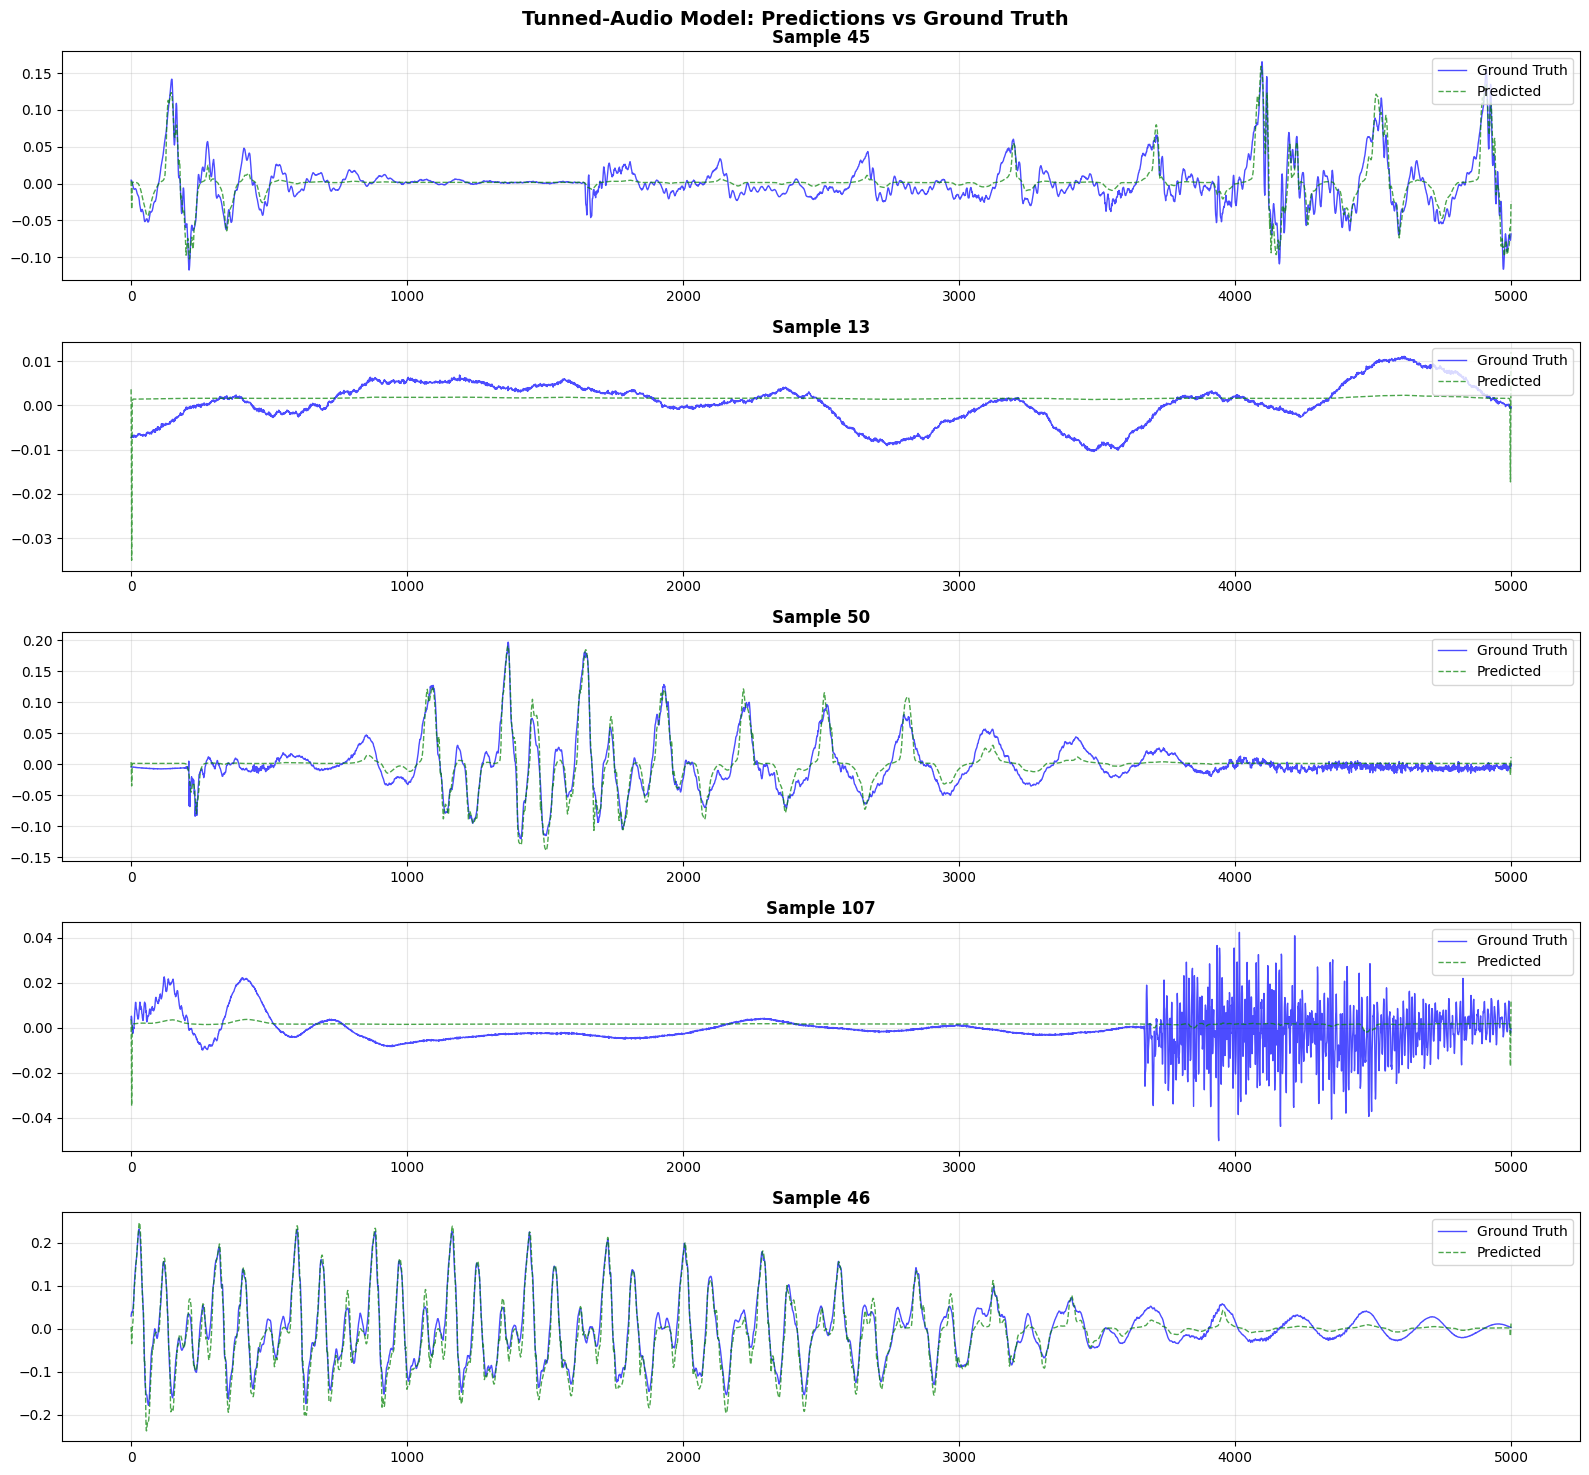

In [12]:
fig, axes = plt.subplots(5, 1, figsize=(16, 15))
indices = random.sample(range(len(y_test)), 5)

for i, idx in enumerate(indices):
    axes[i].plot(y_test[idx], 'b-', label='Ground Truth', linewidth=1, alpha=0.7)
    axes[i].plot(y_pred[idx], 'g--', label='Predicted', linewidth=1, alpha=0.7)
    axes[i].set_title(f'Sample {idx}', fontweight='bold')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Tunned-Audio Model: Predictions vs Ground Truth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()